In [11]:
import pandas as pd
import random

# Define categories
event_types = ['Music', 'Tech', 'Workshop', 'Comedy', 'Sports']
property_types = ['Apartment', 'Villa', 'Studio', 'Bungalow', 'Penthouse']
locations = ['Mumbai', 'Delhi', 'Bangalore', 'Hyderabad', 'Chennai']

# Generate event data
def generate_event_data(n):
    data = []
    for i in range(n):
        data.append({
            'id': f'E{i+1:03}',
            'type': random.choice(event_types),
            'location': random.choice(locations),
            'price': random.randint(100, 1000),
            'popularity': random.randint(100, 1000),
            'duration_hours': random.randint(1, 5)
        })
    return pd.DataFrame(data)

# Generate property data
def generate_property_data(n):
    data = []
    for i in range(n):
        data.append({
            'id': f'P{i+1:03}',
            'type': random.choice(property_types),
            'location': random.choice(locations),
            'price': random.randint(5000, 25000),
            'popularity': random.randint(50, 500),
            'duration_hours': random.randint(6, 72)  # e.g., time on market
        })
    return pd.DataFrame(data)

# Generate datasets
events_df = generate_event_data(25)
properties_df = generate_property_data(25)

# Combine
combined_df = pd.concat([events_df, properties_df], ignore_index=True)

# Save to CSV
combined_df.to_csv("recommendation_dataset.csv", index=False)

print("✅ Dataset saved as recommendation_dataset.csv")


✅ Dataset saved as recommendation_dataset.csv


In [37]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Step 1: Load dataset
df = pd.read_csv("recommendation_dataset.csv")

# Step 2: Preprocessing
categorical_features = ['type', 'location']
numerical_features = ['price', 'popularity', 'duration_hours']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# Step 3: Pipeline with KMeans
kmeans = KMeans(n_clusters=5, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clusterer', kmeans)
])

# Step 4: Fit model and predict clusters
pipeline.fit(df[categorical_features + numerical_features])
df['cluster'] = pipeline.predict(df[categorical_features + numerical_features])

# Save the model
joblib.dump(pipeline, 'kmeans_recommendation_model.pkl')
print("✅ Model saved as kmeans_recommendation_model.pkl")

# Step 5: Recommend similar listings
def recommend_similar(input_row, top_n=5):
    # Predict cluster of input
    cluster = pipeline.predict(pd.DataFrame([input_row]))[0]
    # Get top N other listings in same cluster (excluding identical ones)
    similar_items = df[df['cluster'] == cluster].drop_duplicates().head(top_n)
    return similar_items

# Step 6: Try an example input
example_input = {
    'type': 'Tech',
    'location': 'Delhi',
    'price': 250,
    'popularity': 300,
    'duration_hours': 2
}

recommendations = recommend_similar(example_input)
print("\n🎯 Recommended Similar Listings:")
print(recommendations[['id', 'type', 'location', 'price', 'popularity', 'duration_hours']])


✅ Model saved as kmeans_recommendation_model.pkl

🎯 Recommended Similar Listings:
     id      type   location  price  popularity  duration_hours
0  E001    Comedy    Chennai    176         363               3
2  E003  Workshop  Hyderabad    100         485               5
3  E004    Sports    Chennai    341         245               3
4  E005      Tech  Hyderabad    876         255               5
6  E007    Comedy  Bangalore    447         553               3


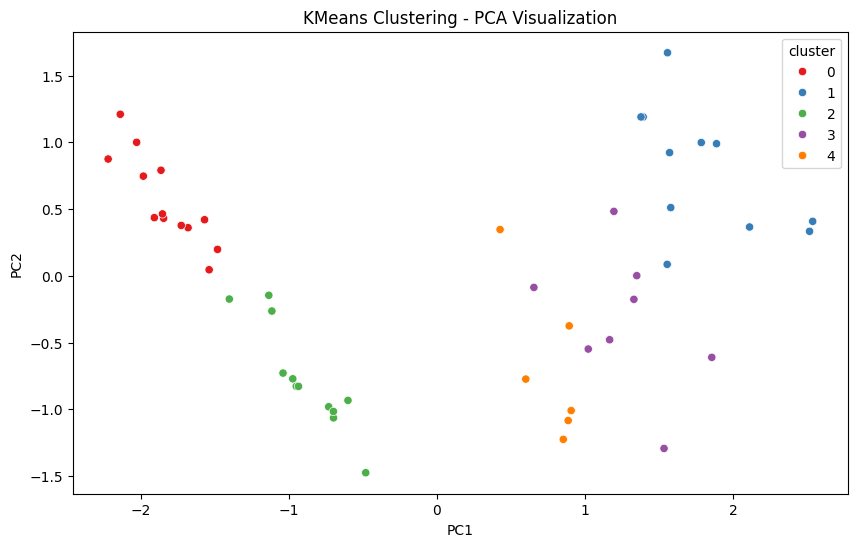

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_transformed is the final features after preprocessing
X_transformed = pipeline.named_steps['preprocessor'].transform(df[categorical_features + numerical_features])
df['cluster'] = pipeline.predict(df[categorical_features + numerical_features])

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)
df['PC1'], df['PC2'] = X_pca[:, 0], X_pca[:, 1]

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster', palette='Set1')
plt.title('KMeans Clustering - PCA Visualization')
plt.show()


In [14]:
from sklearn.metrics.pairwise import euclidean_distances

# Convert sparse matrix to dense
X_dense = X_transformed.toarray()

# Calculate distances
index = 0  # can change to any sample index
distances = euclidean_distances([X_dense[index]], X_dense).flatten()

# Add to DataFrame
df['distance_from_example'] = distances

# Show top 5 most similar listings
recommended_items = df.nsmallest(5, 'distance_from_example')
print(recommended_items[['type', 'location', 'price', 'distance_from_example']])


      type   location  price  distance_from_example
0   Comedy    Chennai    176               0.000000
17  Comedy     Mumbai   1000               1.426024
16  Comedy  Hyderabad    497               1.428202
10  Comedy  Bangalore    538               1.481657
3   Sports    Chennai    341               1.486682


In [15]:
recommended_items.to_csv("recommended_output.csv", index=False)


In [16]:
import mysql.connector
from datetime import datetime

# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="survi09mukh",   # 🔁 replace with your actual MySQL password
    database="eventchain"       # 🔁 replace with your database name
)

cursor = conn.cursor()

# Insert recommendations into the MySQL table
for i, row in recommended_items.iterrows():
    cursor.execute("""
        INSERT INTO recommendations (item_id, type, location, price, cluster, timestamp)
        VALUES (%s, %s, %s, %s, %s, %s)
    """, (i, row['type'], row['location'], row['price'], row['cluster'], datetime.now()))

# Commit and close connection
conn.commit()
conn.close()


In [19]:
import pandas as pd

# Replace 'your_file.csv' with the path to your dataset
data = pd.read_csv("recommendation_dataset.csv")

# Preview
print(data.head())


     id      type   location  price  popularity  duration_hours
0  E001    Comedy    Chennai    176         363               3
1  E002     Music  Bangalore    638         664               5
2  E003  Workshop  Hyderabad    100         485               5
3  E004    Sports    Chennai    341         245               3
4  E005      Tech  Hyderabad    876         255               5


In [24]:
from sklearn.model_selection import train_test_split

# Target variable is 'price'
X = data.drop('price', axis=1)
y = data['price']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# Load your dataset
data = pd.read_csv('recommendation_dataset.csv')  # Already loaded in your case

# Target and Features
X = data.drop(['price', 'id'], axis=1)
y = data['price']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numeric features
categorical_features = ['type', 'location']
numerical_features = ['popularity', 'duration_hours']

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# Model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit model
model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


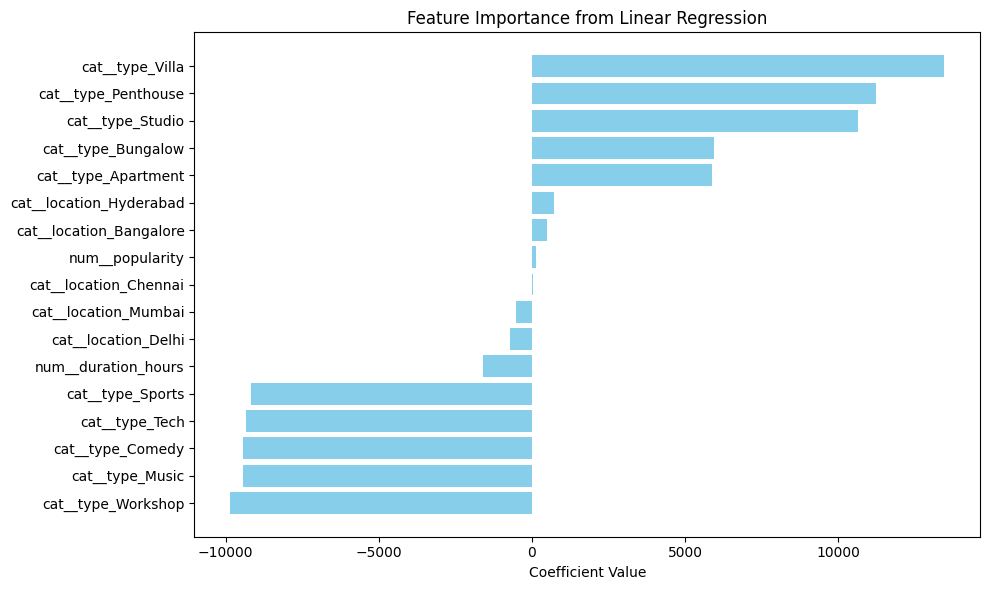

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_csv("recommendation_dataset.csv")  # replace with actual path

# Define features and target
X = data.drop(columns=["price"])
y = data["price"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
categorical = ["type", "location"]
numerical = ["popularity", "duration_hours"]

preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical),
    ("num", StandardScaler(), numerical)
])

# Pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train model
model.fit(X_train, y_train)

# Get coefficients
coefficients = model.named_steps['regressor'].coef_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Plot feature importances
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": coefficients
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("Feature Importance from Linear Regression")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


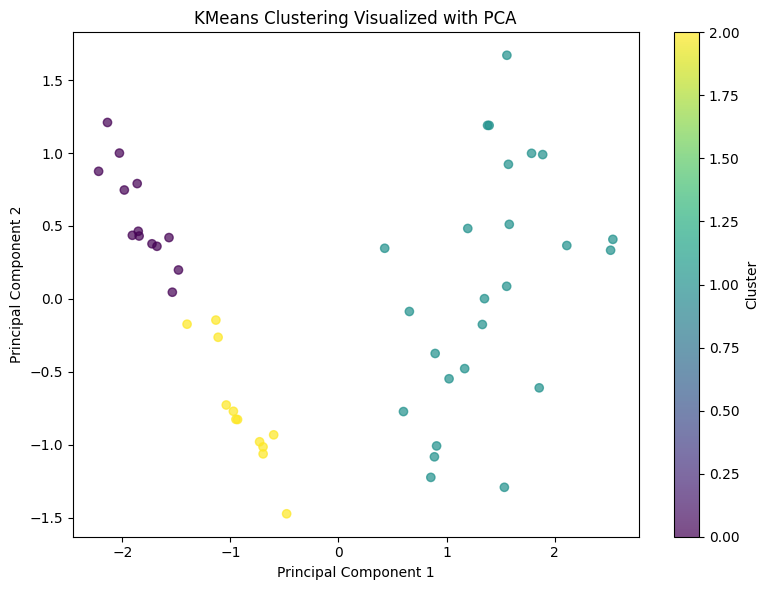

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Load your data
data = pd.read_csv("recommendation_dataset.csv")  # Replace with your actual file

# Features to use for clustering
features = ['type', 'location', 'price', 'popularity', 'duration_hours']
X = data[features]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['price', 'popularity', 'duration_hours']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['type', 'location'])
])

X_transformed = preprocessor.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_transformed)

# PCA for visualization (2D)
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_transformed.toarray())  # Convert sparse matrix to dense if needed

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title("KMeans Clustering Visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()


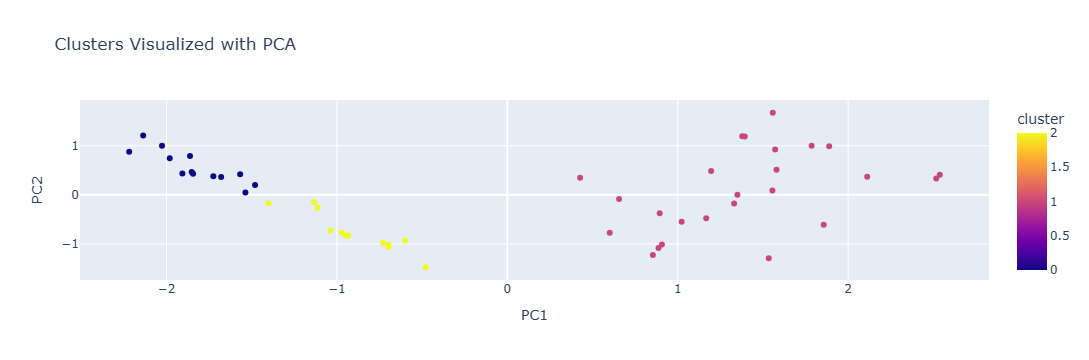

In [34]:
import plotly.express as px

df_viz = pd.DataFrame(X_2D, columns=["PC1", "PC2"])
df_viz['cluster'] = labels

px.scatter(df_viz, x='PC1', y='PC2', color='cluster', title="Clusters Visualized with PCA")


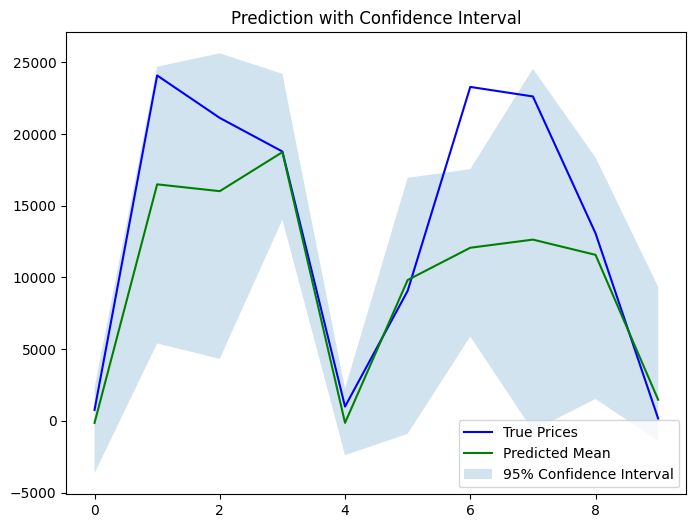

In [35]:
from sklearn.utils import resample
import numpy as np

predictions = []
for _ in range(100):
    X_resample, y_resample = resample(X_train, y_train)
    model.fit(X_resample, y_resample)
    pred = model.predict(X_test)
    predictions.append(pred)

predictions = np.array(predictions)
lower = np.percentile(predictions, 2.5, axis=0)
upper = np.percentile(predictions, 97.5, axis=0)

# Visualize confidence
plt.figure(figsize=(8, 6))
plt.plot(y_test.values, label="True Prices", color='blue')
plt.plot(np.mean(predictions, axis=0), label="Predicted Mean", color='green')
plt.fill_between(range(len(lower)), lower, upper, alpha=0.2, label="95% Confidence Interval")
plt.legend()
plt.title("Prediction with Confidence Interval")
plt.show()


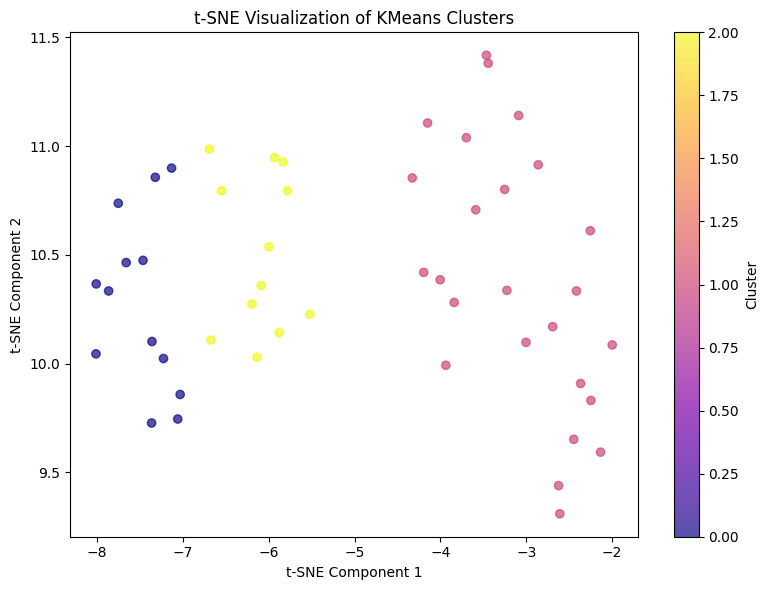

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

# Load dataset
data = pd.read_csv("recommendation_dataset.csv")  # Replace with your actual file

# Select features
features = ['type', 'location', 'price', 'popularity', 'duration_hours']
X = data[features]

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['price', 'popularity', 'duration_hours']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['type', 'location'])
])

X_transformed = preprocessor.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_transformed)

# t-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2D = tsne.fit_transform(X_transformed.toarray())  # toarray() for sparse matrix

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=labels, cmap='plasma', alpha=0.7)
plt.title("t-SNE Visualization of KMeans Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()


In [39]:
import pandas as pd
import joblib
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Sample dataset (replace this with your actual merged dataset)
data = pd.read_csv("recommendation_dataset.csv")  # if not already loaded

# Features to use for clustering
features = ['type', 'location', 'price', 'popularity', 'duration_hours']

X = data[features]

# Define preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['type', 'location']),
    ('num', StandardScaler(), ['price', 'popularity', 'duration_hours'])
])

# Create final KMeans pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=4, random_state=42))
])

# Fit model
model.fit(X)

# Save the model
joblib.dump(model, 'kmeans_recommendation_model.pkl')

# Save data with cluster labels (optional for dashboard)
data['cluster'] = model.predict(X)
data.to_csv('recommendation_dataset.csv', index=False)

print("✅ Model and data saved successfully.")


✅ Model and data saved successfully.
